In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random
from importlib import reload
import warnings
import ot
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import ListedColormap

import surprise as sup

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

# local imports
import anndata_utils as anntools

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

In [2]:
resolution = 1000000
chrom = "chr2"

dpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/"

file_list = sorted(glob.glob(f"{dpath}*_{resolution}_{chrom}*"))
print(file_list)

population_path = file_list[0]
singlecell_path = file_list[1]

print()

print(f"{population_path=}")
print(f"{singlecell_path=}")

['/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/population_mESC_1000000_chr2.h5ad', '/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/singlecell_mESC_1000000_chr2.h5ad']

population_path='/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/population_mESC_1000000_chr2.h5ad'
singlecell_path='/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/singlecell_mESC_1000000_chr2.h5ad'


# load population

In [3]:
start_time = time.time()  # Record the start time
adata = sc.read_h5ad(population_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()
adata

Time taken to read the file: 1.70 seconds
Memory usage: current 0.95 GB, difference +0.95 GB


AnnData object with n_obs × n_vars = 179 × 186499
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'

# load single-cell

In [4]:
start_time = time.time()  # Record the start time
bdata = sc.read_h5ad(singlecell_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()
bdata

Time taken to read the file: 33.33 seconds
Memory usage: current 2.86 GB, difference +1.91 GB


AnnData object with n_obs × n_vars = 179 × 1865516
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'

# QC

In [5]:
def find_outliers_iqr(df_column):
  """
  Identifies outliers in a pandas DataFrame column using the IQR method.

  Args:
    df_column: A pandas Series representing the column to analyze.

  Returns:
    A boolean mask with True for outliers and False otherwise.
  """
  Q1 = df_column.quantile(0.15)
  Q3 = df_column.quantile(0.85)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (df_column < lower_bound) | (df_column > upper_bound)

adata.obs['degree_outlier'] = find_outliers_iqr(adata.obs['chrom_degree'])

adata.obs[adata.obs['degree_outlier']][['chrom_bin', 'chrom_degree', 'degree_outlier']].head()

,chrom_bin,chrom_degree,degree_outlier
bin_name,,,
chr2:98,98,93161,True
chr2:177,177,3700,True
chr2:181,181,1340,True


In [6]:
# remove outliers
remove_bins = adata.obs[adata.obs['degree_outlier']].index.to_list()
print(f"Removing top {len(remove_bins)} outlier loci: ")
print(remove_bins)

adata = adata[~adata.obs_names.isin(remove_bins), :].copy()
bdata = bdata[~bdata.obs_names.isin(remove_bins), :].copy()

print('done!')

Removing top 3 outlier loci: 
['chr2:98', 'chr2:177', 'chr2:181']
done!


# Clique-expand

In [7]:
matrix.expand_and_normalize_anndata(adata, oe_kr=True)
print()
matrix.expand_and_normalize_anndata(bdata, oe_kr=True)

adata

Expanding input matrix...
Applying KR normalization...
Applying OE normalization...
Normalization complete.

Expanding input matrix...
Applying KR normalization...
Applying OE normalization...
Normalization complete.


AnnData object with n_obs × n_vars = 176 × 186499
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree', 'degree_outlier'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'
    obsm: 'A', 'A_kr', 'A_oe', 'A_oe_kr'

# Centrality measures

In [8]:
ce_centralities = {
    'ce_degree_centrality' : {
        'function' : nx.degree_centrality,
        'weight' : False
    },
    'ce_closeness_centrality' : {
        'function' : nx.closeness_centrality,
        'weight' : False
    },
    'ce_eigenvector_centrality' : {
        'function' : nx.eigenvector_centrality,
        'weight' : True
    },
    'ce_betweenness_centrality' : {
        'function' : nx.betweenness_centrality,
        'weight' : True
    },
    'ce_pagerank' : {
        'function' : nx.pagerank,
        'weight' : True
    },
}

obsm_key = 'A_oe'
A = adata.obsm[obsm_key].copy()
# A = A.mask(np.eye(A.shape[0], dtype=bool), 0)

G = nx.from_pandas_adjacency(A)
print(G)

for label, d in ce_centralities.items():
    if d['weight']:
        centrality = d['function'](G, weight='weight')
    else:
        centrality = d['function'](G)
        
    adata.obs[label] = adata.obs.index.map(centrality)
    adata.obs[label] = ut.min_max(adata.obs[label])

adata.obs[list(ce_centralities.keys())].head()

Graph with 176 nodes and 15549 edges


,ce_degree_centrality,ce_closeness_centrality,ce_eigenvector_centrality,ce_betweenness_centrality,ce_pagerank
bin_name,,,,,
chr2:3,1.0,1.000000,0.369326,0.177194,0.379051
chr2:4,0.5,0.497159,0.418013,0.049221,0.427527
chr2:5,1.0,1.000000,0.540510,0.008203,0.530948
chr2:6,1.0,1.000000,0.522232,0.080394,0.532509
chr2:7,1.0,1.000000,0.310589,0.148482,0.333318


Wed Jan  1 13:25:54 2025 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Wed Jan  1 13:25:54 2025 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


                           ce_eigenvector_centrality  ATACSeq_1     RNA_5
ce_eigenvector_centrality                   1.000000   0.391811  0.165051
ATACSeq_1                                   0.391811   1.000000  0.278544
RNA_5                                       0.165051   0.278544  1.000000


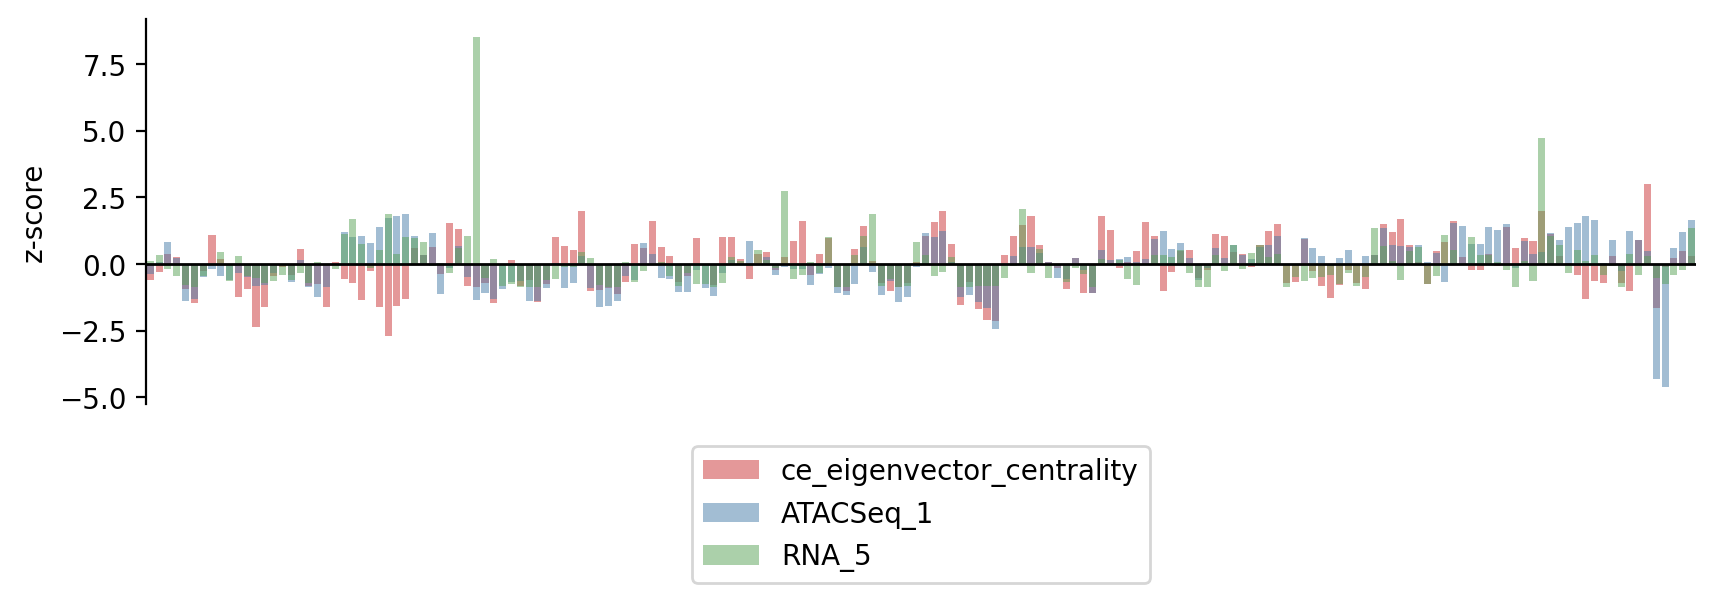

In [9]:
columns = [
    'ce_eigenvector_centrality',
    'ATACSeq_1',
    'RNA_5',
]

pdf = adata.obs.copy()

for column in columns:
    pdf[column] = scipy.stats.zscore(pdf[column])

print(pdf[columns].corr())

pdf = pdf[columns + ['chrom_bin']].melt(id_vars='chrom_bin')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 2.5

sns.barplot(
    data=pdf,
    x='chrom_bin',
    y='value',
    hue='variable',
    palette='Set1',
    dodge=False,
    alpha=0.5,
)

sns.move_legend(
    plt.gca(),
    title="",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.5),
)

plt.axhline(y=0, lw=1, c='k')
plt.xticks([])
plt.ylabel('z-score')
plt.xlabel('')
sns.despine(bottom=True)

# higher-order centralities

In [10]:
# def balance_incidence_matrix(matrix, reg=0.85):
#     """Balances a sparse matrix to be doubly stochastic using Sinkhorn-Knopp.

#     Args:
#         matrix: A scipy.sparse matrix.
#         reg: Regularization parameter for Sinkhorn-Knopp algorithm.

#     Returns:
#         A balanced sparse matrix.
#     """
#     start_time = time.time()
#     matrix = matrix.toarray()  # Convert to dense array for POT
#     a = np.ones(matrix.shape[0]) / matrix.shape[0]  # Uniform row distribution
#     b = np.ones(matrix.shape[1]) / matrix.shape[1]  # Uniform column distribution
#     balanced_matrix = ot.sinkhorn(a, b, matrix, reg)  # Use input regularization parameter
#     end_time = time.time()
#     print(f"Balancing matrix took: {end_time - start_time:.2f} seconds")
#     return csr_matrix(balanced_matrix)  # Convert back to sparse

In [11]:
# add the principal singular value of the incidence matrix
H = adata.to_df().copy()
print(f"Raw: {H.shape=}")
H = H.T.drop_duplicates().T
print(f"De-duped: {H.shape=}")

node_weight_attr = 'ATACSeq_1' # must be an obs column
node_weights = adata.obs.loc[H.index, node_weight_attr].values


svd = TruncatedSVD(n_components=1, n_iter=10)
adata.obs['singular_vector_1'] = ut.min_max(svd.fit_transform(H))

# hypergraph centralities
hge_functions = {
    'hge_linear_unweighted' : {
        'function' : 'linear',
        'weights' : None,
    },
    'hge_linear_degree_weighted' : {
        'function' : 'linear',
        'weights' : 1 / (H.sum(axis=1).values + 1),
    },
    'hge_linear_RNA_weighted' : {
        'function' : 'linear',
        'weights' : 1 / (adata.obs.loc[H.index, 'RNA_2'].values + 1)
    },
    'hge_linear_ATAC_weighted' : {
        'function' : 'linear',
        'weights' : 1 / (adata.obs.loc[H.index, 'ATACSeq_1'].values + 1)
    },
    'hge_logexp_unweighted' : {
        'function' : 'log-exp',
        'weights' : None,
    },
    'hge_logexp_degree_weighted' : {
        'function' : 'log-exp',
        'weights' : 1 / (H.sum(axis=1).values + 1),
    },
    'hge_logexp_RNA_weighted' : {
        'function' : 'log-exp',
        'weights' : 1 / (adata.obs.loc[H.index, 'RNA_2'].values + 1)
    },
    'hge_logexp_ATAC_weighted' : {
        'function' : 'log-exp',
        'weights' : 1 / (adata.obs.loc[H.index, 'ATACSeq_1'].values + 1)
    },
}


hge_centralities = []

for label, d in hge_functions.items():
    start_time = time.time()  # Record start time
    node, edge = central.nonlinear_eigenvector_centrality(
        H,
        function=d['function'],
        node_weights=d['weights'],
    )

    hge_centralities.append(label)
    adata.obs[label] = ut.min_max(node)

    end_time = time.time()  # Record end time
    print(f"{label} calculation took: {end_time - start_time:.2f} seconds")

adata

Raw: H.shape=(176, 186499)
De-duped: H.shape=(176, 45833)
hge_linear_unweighted calculation took: 0.60 seconds
hge_linear_degree_weighted calculation took: 0.58 seconds
hge_linear_RNA_weighted calculation took: 0.54 seconds
hge_linear_ATAC_weighted calculation took: 0.53 seconds
hge_logexp_unweighted calculation took: 0.25 seconds
hge_logexp_degree_weighted calculation took: 0.20 seconds
hge_logexp_RNA_weighted calculation took: 0.27 seconds
hge_logexp_ATAC_weighted calculation took: 0.27 seconds


AnnData object with n_obs × n_vars = 176 × 186499
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree', 'degree_outlier', 'ce_degree_centrality', 'ce_closeness_centrality', 'ce_eigenvector_centrality', 'ce_betweenness_centrality', 'ce_pagerank', 'singular_vector_1', 'hge_linear_unweighted', 'hge_linear_degree_weighted', 'hge_linear_RNA_weighted', 'hge_linear_ATAC_weighted', 'hge_logexp_unweighted', 'hge_logexp_degree_weighted', 'hge_logexp_RNA_weighted', 'hge_logexp_ATAC_weighted'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'
    obsm: 'A', 'A_kr', 'A_oe', 'A_oe_kr'

In [12]:
# columns = {
#     'hge_linear_unweighted': False,
#     'hge_logexp_unweighted': False,
#     'hge_logexp_RNA_weighted': False,
#     'ce_eigenvector_centrality': False,
#     'ATACSeq_1': False,
#     'CTCF': False,
#     'H3K27ac': False,
#     'H3K27me3': False,
#     'RNA_5': True,
# }

# colors = {
#     'hge_linear_unweighted': '#00BFFF',  # Vivid blue
#     'hge_logexp_unweighted': '#00BFFF',  # Vivid blue
#     'hge_logexp_RNA_weighted': '#00BFFF',  # Vivid blue
#     'ce_eigenvector_centrality': '#00BFFF',  # Vivid blue
#     'ATACSeq_1': '#006400',          # Deep green
#     'CTCF': '#0000FF',              # Pure blue
#     'H3K27ac': '#E41A1C',            # Bright red
#     'H3K27me3': '#800080',          # Intense purple
#     'RNA_5': '#FFA500',            # Orange-gold (for distinction)
# }

# pdf = adata.obs.copy()

# for column in columns:
#     pdf[column] = scipy.stats.zscore(pdf[column])

# # print(pdf[list(columns.keys())].corr())

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 10, 2.5

# for column, log_scale in columns.items():
#     if log_scale:
#         pdf[column] = np.log1p(pdf[column])

#     pdf_melt = pdf[['chrom_bin', column]].melt(id_vars='chrom_bin')
#     print(column, colors[column])

#     # sns.barplot(
#     #     data=pdf_melt,
#     #     x='chrom_bin',
#     #     y='value',
#     #     color=colors[column], 
#     #     dodge=False,
#     #     alpha=0.5,
#     #     legend=False,
#     # )

#     sns.lineplot(
#         data=pdf_melt,
#         x='chrom_bin',
#         y='value',
#         color=colors[column], 
#         # dodge=False,
#         alpha=0.5,
#         legend=False,
#     )

#     plt.axhline(y=0, lw=1, c='k')
#     plt.xticks([])
#     plt.ylabel('z-score')
#     plt.xlabel('')
#     plt.title(column)
#     sns.despine(bottom=True)
#     plt.show()
#     break

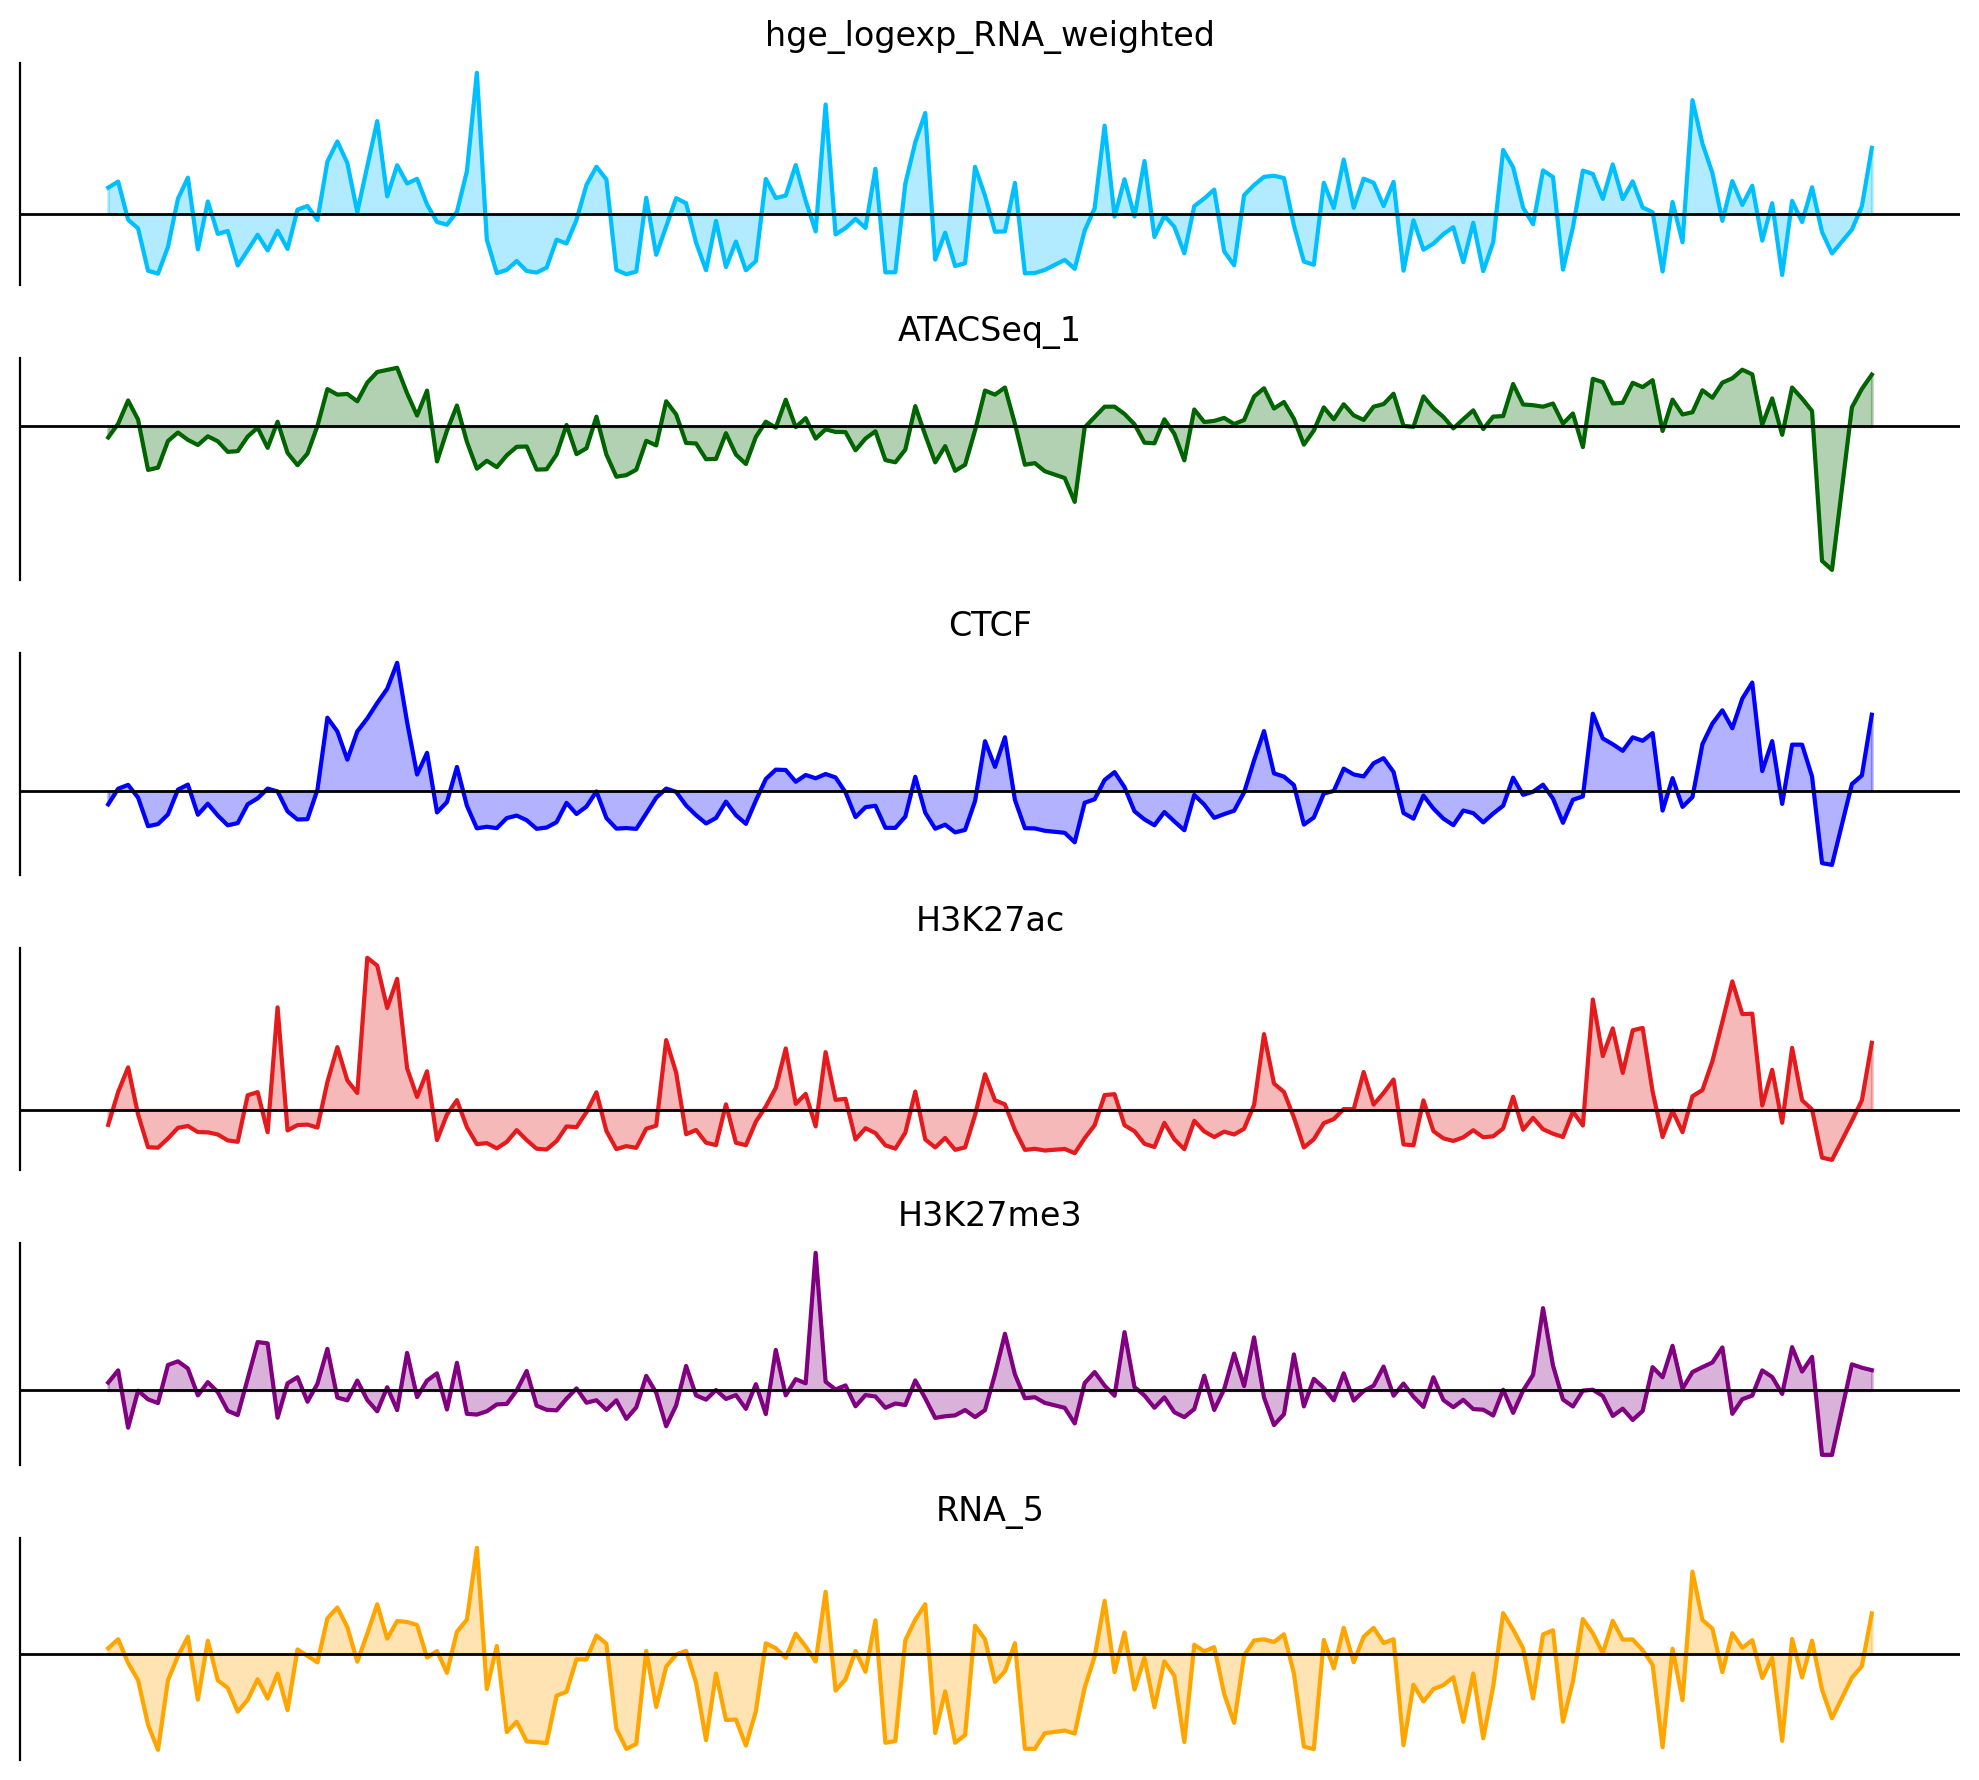

In [13]:
columns = {
    # 'hge_linear_unweighted': False,
    # 'hge_logexp_unweighted': False,
    'hge_logexp_RNA_weighted': False,
    # 'ce_eigenvector_centrality': False,
    'ATACSeq_1': False,
    'CTCF': False,
    'H3K27ac': False,
    'H3K27me3': False,
    'RNA_5': True,
}

colors = {
    # 'hge_linear_unweighted': '#00BFFF',  # Vivid blue
    # 'hge_logexp_unweighted': '#00BFFF',  # Vivid blue
    'hge_logexp_RNA_weighted': '#00BFFF',  # Vivid blue
    # 'ce_eigenvector_centrality': '#00BFFF',  # Vivid blue
    'ATACSeq_1': '#006400',          # Deep green
    'CTCF': '#0000FF',              # Pure blue
    'H3K27ac': '#E41A1C',            # Bright red
    'H3K27me3': '#800080',          # Intense purple
    'RNA_5': '#FFA500',            # Orange-gold
}

pdf = adata.obs.copy()

for column in columns:
    pdf[column] = scipy.stats.zscore(pdf[column])

# print(pdf[list(columns.keys())].corr())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 2

# Create a single figure with subplots
fig, axes = plt.subplots(len(columns), 1, figsize=(10, 1.5 * len(columns)), sharex=True)

# Iterate through columns and plot on subplots
for i, (column, log_scale) in enumerate(columns.items()):
    if log_scale:
        pdf[column] = np.log1p(pdf[column])

    pdf_melt = pdf[['chrom_bin', column]].melt(id_vars='chrom_bin')

    sns.lineplot(
        data=pdf_melt,
        x='chrom_bin',
        y='value',
        color=colors[column],
        ax=axes[i]  # Plot on the corresponding subplot
    )

    # Fill the area
    axes[i].fill_between(
        pdf_melt['chrom_bin'], 
        pdf_melt['value'],
        color=colors[column],
        alpha=0.3,
    )

    axes[i].axhline(y=0, lw=1, c='k')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_ylabel('')
    axes[i].set_title(column)
    sns.despine(bottom=True, ax=axes[i])

plt.xlabel('')  # Set x-label for the entire figure
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [14]:
# break

In [15]:
# columns = [
#     'ce_eigenvector_centrality',
#     'hge_logexp_unweighted',
# ]

# pdf = adata.obs.copy()

# for column in columns:
#     pdf[column] = scipy.stats.zscore(pdf[column])

# print(pdf[columns].corr())

# pdf = pdf[columns + ['chrom_bin']].melt(id_vars='chrom_bin')

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 10, 2.5

# sns.barplot(
#     data=pdf,
#     x='chrom_bin',
#     y='value',
#     hue='variable',
#     palette='Set1',
#     dodge=False,
#     alpha=0.5,
# )

# sns.move_legend(
#     plt.gca(),
#     title="",
#     loc='lower center',
#     bbox_to_anchor=(0.5, -0.5),
# )

# plt.axhline(y=0, lw=1, c='k')
# plt.xticks([])
# plt.ylabel('z-score')
# plt.xlabel('')
# sns.despine(bottom=True)

In [16]:
# columns = [
#     'hge_logexp_RNA_weighted',
#     'ATACSeq_1',
#     'RNA_5',
# ]

# pdf = adata.obs.copy()

# for column in columns:
#     pdf[column] = scipy.stats.zscore(pdf[column])

# print(pdf[columns].corr())

# pdf = pdf[columns + ['chrom_bin']].melt(id_vars='chrom_bin')

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 10, 2.5

# sns.barplot(
#     data=pdf,
#     x='chrom_bin',
#     y='value',
#     hue='variable',
#     palette='Set1',
#     dodge=False,
#     alpha=0.5,
# )

# sns.move_legend(
#     plt.gca(),
#     title="",
#     loc='lower center',
#     bbox_to_anchor=(0.5, -0.5),
# )

# plt.axhline(y=0, lw=1, c='k')
# plt.xticks([])
# plt.ylabel('z-score')
# plt.xlabel('')
# sns.despine(bottom=True)

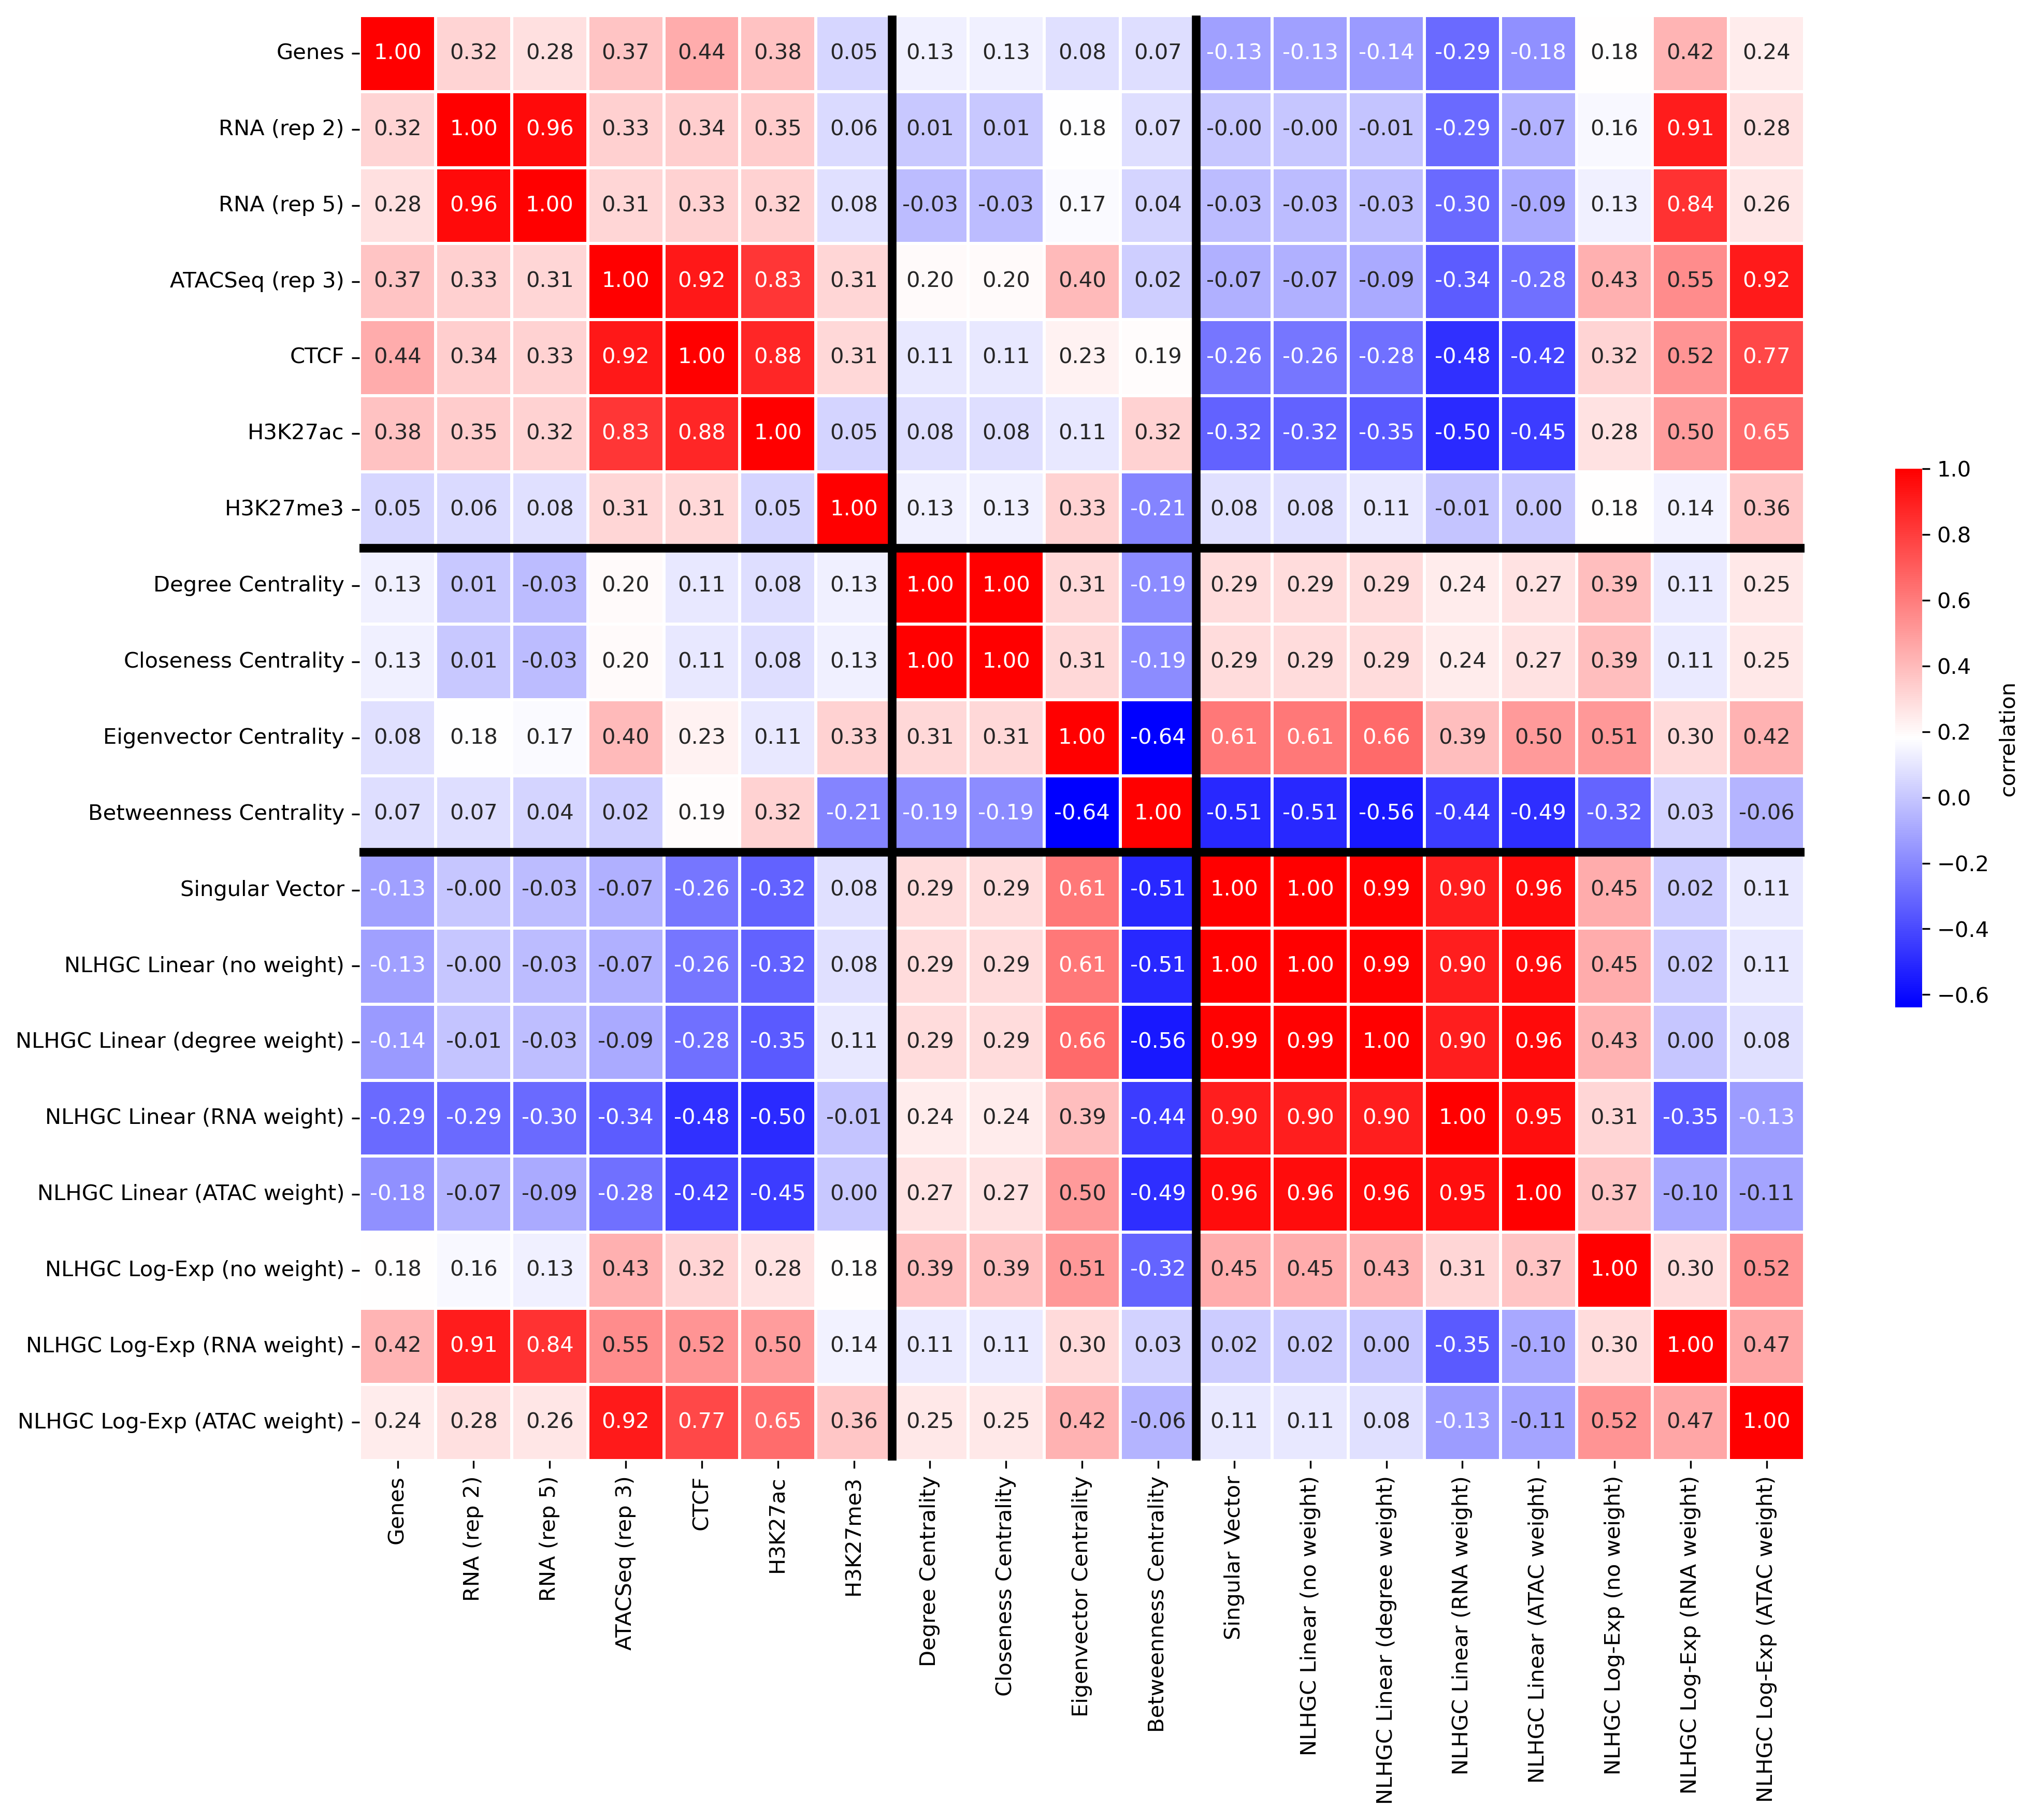

In [17]:
pdf = adata.obs.copy()

column_labels = {
    'n_genes': "Genes",
    'RNA_2': "RNA (rep 2)",
    'RNA_5': "RNA (rep 5)",
    'ATACSeq_3': "ATACSeq (rep 3)",
    'CTCF': "CTCF",
    'H3K27ac': "H3K27ac",
    'H3K27me3': "H3K27me3",
    'ce_degree_centrality': "Degree Centrality",
    'ce_closeness_centrality': "Closeness Centrality",
    'ce_eigenvector_centrality': "Eigenvector Centrality",
    'ce_betweenness_centrality': "Betweenness Centrality",
    'singular_vector_1': "Singular Vector",
    'hge_linear_unweighted' : "NLHGC Linear (no weight)",
    'hge_linear_degree_weighted' : "NLHGC Linear (degree weight)",
    'hge_linear_RNA_weighted' : "NLHGC Linear (RNA weight)",
    'hge_linear_ATAC_weighted' : "NLHGC Linear (ATAC weight)",
    'hge_logexp_unweighted' : "NLHGC Log-Exp (no weight)",
    'hge_logexp_RNA_weighted' : "NLHGC Log-Exp (RNA weight)",
    'hge_logexp_ATAC_weighted' : "NLHGC Log-Exp (ATAC weight)",
}

corr = pdf[list(column_labels.keys())].corr()
corr.index = list(column_labels.values())
corr.columns = list(column_labels.values())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 15

sns.heatmap(
    corr, 
    square=True,
    linewidths=1,
    cmap='bwr',
    annot=True,
    fmt=".2f",  # Format to show only 3 decimal places
    cbar_kws={'shrink': 0.3, 'label' : 'correlation'}
)

# Get the positions of the lines
# These positions are based on the order of your `column_labels`
lines = [7, 11,]

# Add vertical lines
for line in lines:
    plt.axvline(line, color='black', lw=4)
    plt.axhline(line, color='black', lw=4)


plt.show()

In [18]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Identify core in single-cells

In [ ]:
core_threshold_quantile = 0.75
order_threshold = 2

centrality_columns = [
    'ce_eigenvector_centrality',
    'singular_vector_1',
    'hge_logexp_unweighted',
    'hge_logexp_RNA_weighted',
    'hge_logexp_ATAC_weighted',
]

feature_columns = [
    'n_genes',
    'RNA_2', 
    'ATACSeq_3', 
    'CTCF',
    'H3K27ac',
    'H3K27me3',
]

for column in centrality_columns:
    vector = adata.obs[column].values

    # identify the core nodes from population data
    threshold = np.quantile(vector, core_threshold_quantile)
    core_nodes = adata.obs[adata.obs[column] > threshold].index.to_list()
    highest_nodes = adata.obs[column].sort_values(ascending=False).head(5).index.to_list()

    print(f"\n{column}:")
    print(f"  - Threshold: {threshold:.3f} ({core_threshold_quantile} quantile)")
    print(f"  - Core nodes: {len(core_nodes)} ({100*(len(core_nodes) / len(adata)):.2f}%)")
    print(f"  - Most central nodes: {highest_nodes}") 

    # extract the core from population
    core = adata[core_nodes, :].copy()
    core = core[:, core.X.sum(axis=0) > order_threshold].copy()
    print(f"  - Population core size: {core.shape}") 

    # compute the higher order laplacian
    L = matrix.normalized_hypergraph_laplacian(core.X)
    fiedler = matrix.estimate_fiedler(L)
    entropy = matrix.hypergraph_entropy(L)
    print(f"  - Fiedler number of population core: {fiedler:.4f}") 
    print(f"  - Hypergraph entropy of population core: {entropy:.4f}") 
    
    # extract the single-cell core
    core = bdata[core_nodes, :].copy()
    core = core[:, core.X.sum(axis=0) > order_threshold].copy()
    print(f"  - Sinlge-cell core size: {core.shape}") 

    n_cells = core.var['basename'].nunique()
    print(f"  - Sinlge-cells with hyperedges between core nodes: {n_cells} ({100*(n_cells / 380):.2f}%)") 

    # compute the higher order laplacian
    L = matrix.normalized_hypergraph_laplacian(core.X)
    fiedler = matrix.estimate_fiedler(L)
    entropy = matrix.hypergraph_entropy(L)
    print(f"  - Fiedler number of single-cell core: {fiedler:.4f}") 
    print(f"  - Hypergraph entropy of single-cell core: {entropy:.4f}") 

    # plot the features 
    print()
    feature_df = adata.obs.copy()
    feature_df = feature_df[feature_columns]
    feature_df['in_core'] = feature_df.index.isin(core_nodes)
    feature_df = feature_df.groupby('in_core').mean().T
    print(feature_df.to_markdown())

    # break

print('done!')

# plot the core nodes

In [ ]:
adata.obs.columns

In [ ]:
obsm_key = 'A_kr'
core_score = 'hge_logexp_RNA_weighted'
edge_threshold_quantile = 0.65
core_threshold_quantile = 0.75
order_threshold = 2

vector = adata.obs[core_score].values
threshold = np.quantile(vector, core_threshold_quantile)
core_nodes = adata.obs[adata.obs[core_score] > threshold].index.to_list()

node_attributes = adata.obs.copy()
node_attributes['core'] = node_attributes.index.isin(core_nodes)
node_attributes = node_attributes.to_dict(orient='index')

# define the graph
A = adata.obsm[obsm_key].copy()
A = A.mask(np.eye(A.shape[0], dtype=bool), 0)
threshold = np.quantile(A, edge_threshold_quantile)
A[A < threshold] = 0
G = nx.from_pandas_adjacency(A)
nx.set_node_attributes(G, node_attributes)

G.pos = nx.spring_layout(G)
print(G)

node_colors = ['red' if G.nodes[node]['core'] else 'blue' for node in G.nodes]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

nx.draw_networkx_nodes(
    G, 
    G.pos,
    node_size=25,
    node_color=node_colors,
    edgecolors='black', 
    linewidths=0.5,      
)

nx.draw_networkx_edges(
    G, 
    G.pos,
    width=[(d['weight'] * 10) for u, v, d in G.edges(data=True)],
)

sns.despine(left=True, bottom=True)

In [ ]:
adata.obs.columns

In [ ]:
color_by = 'bin_start'

node_colors = [np.log1p(G.nodes[node][color_by]) for node in G.nodes]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

nx.draw_networkx_nodes(
    G, 
    G.pos,
    node_size=25,
    node_color=node_colors,
    cmap='gnuplot',
    edgecolors='black', 
    linewidths=0.5,      
)

nx.draw_networkx_edges(
    G, 
    G.pos,
    width=[(d['weight'] * 10) for u, v, d in G.edges(data=True)],
)

sns.despine(left=True, bottom=True)

In [ ]:
plt2.make_colorbar(
    cmap='gnuplot',
    width=0.2,
    height=3,
    title=color_by,
    tick_labels=["Low", "High"]
)

# UMAP Approach

In [ ]:
# umap_features = [    
#     'ATACSeq_3',
#     'CTCF',
#     'H3K27ac',
#     'H3K27me3', 
#     'RNA_2', 
#     'ce_eigenvector_centrality',
#     'singular_vector_1',
#     'hge_logexp_unweighted',
#     'hge_logexp_RNA_weighted',
#     'hge_logexp_ATAC_weighted',
# ]

# adata.obsm['X_features'] = adata.obs[umap_features].copy()

# sc.pp.neighbors(
#     adata, 
#     use_rep='X_features',
#     n_neighbors=5,
# )

# sc.tl.umap(
#     adata,
# )

# adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
# adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 3, 3

# sns.scatterplot(
#     data=adata.obs,
#     x='UMAP 1',
#     y='UMAP 2',
#     ec='none',
# )

# plt.yticks([])
# plt.xticks([])
# sns.despine()

In [ ]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 4, 4

# cmap = 'hot_r'
# colorbars = False

# for feature in umap_features:
#     sns.scatterplot(
#         data=adata.obs,
#         x='UMAP 1',
#         y='UMAP 2',
#         ec='k',
#         s=35,
#         hue=feature,
#         palette=cmap,
#         legend=False,
#     )

#     plt.yticks([])
#     plt.xticks([])
#     plt.title(feature)
#     sns.despine()
#     plt.show()
    
#     if colorbars:
#         plt2.make_colorbar(cmap=cmap, tick_labels=['Low', 'High'])
#         plt.show()

#     # break

# Extract the core

In [ ]:
core_score = 'hge_logexp_RNA_weighted'
core_threshold_quantile = 0.75
order_threshold = 2

vector = adata.obs[core_score].values
threshold = np.quantile(vector, core_threshold_quantile)
core_nodes = adata.obs[adata.obs[core_score] > threshold].index.to_list()

# extract the core from population
core = adata[core_nodes, :].copy()
core = core[:, core.X.sum(axis=0) > order_threshold].copy()

H_core = core.to_df()
print(f"{H_core.shape=}")
core_reads = H_core.columns.to_list()
H_core.columns = [f"core_{x}" for x in H_core.columns]
H_core.head()

# Plot the  core

In [ ]:
n_reads = 10000

H = adata.to_df().sample(n_reads, axis=1)
H = ut.sort_by_lowest_index(H)

rows, cols = np.nonzero(H)

# Create a mapping from column index to color
color_map = {i: 'r' if x in core_reads else 'lightgrey' for i, x in enumerate(H.columns)}

# Assign colors based on the column index of each point
colors = [color_map[col] for col in cols]

# Separate core and non-core points
core_rows = [row for row, col in zip(rows, cols) if color_map[col] == 'r']
core_cols = [col for row, col in zip(rows, cols) if color_map[col] == 'r']
non_core_rows = [row for row, col in zip(rows, cols) if color_map[col] == 'lightgrey']
non_core_cols = [col for row, col in zip(rows, cols) if color_map[col] == 'lightgrey']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4

# Plot non-core points first
plt.scatter(non_core_cols, non_core_rows, marker="s", s=1, c='lightgrey', alpha=0.75)

# Plot core points on top
plt.scatter(core_cols, core_rows, marker="s", s=1, c='r', alpha=0.75) 

plt.gca().invert_yaxis()
plt.xticks([])

sns.despine()

plt.show()

In [ ]:
adata.obs.columns

In [ ]:
feature = "ATACSeq_2"
core_color = "r"
periphery_color = "lightgrey"
feature_color = "red"
n_reads = 50000
size = 1

H = adata.to_df().sample(n_reads, axis=1)
H = ut.sort_by_lowest_index(H)
print(f"{H.shape=}")

rows, cols = np.nonzero(H)

# Create a mapping from column index to color
color_map = {i: core_color if x in core_reads else periphery_color for i, x in enumerate(H.columns)}

# Assign colors based on the column index of each point
colors = [color_map[col] for col in cols]

# Separate core and non-core points
core_rows = [row for row, col in zip(rows, cols) if color_map[col] == core_color]
core_cols = [col for row, col in zip(rows, cols) if color_map[col] == core_color]
non_core_rows = [row for row, col in zip(rows, cols) if color_map[col] == periphery_color]
non_core_cols = [col for row, col in zip(rows, cols) if color_map[col] == periphery_color]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4

# Plot non-core points first
plt.scatter(
    non_core_cols, 
    non_core_rows, 
    marker="o",
    s=size,
    c=periphery_color,
    alpha=0.5,
)

# Plot core points on top
plt.scatter(
    core_cols, 
    core_rows, 
    marker="o",
    s=size,
    c=core_color, 
    alpha=0.75,
) 

ax = plt.gca()
ax.invert_yaxis()
ax.set_xticks([])

obs = adata.obs.copy()
obs = obs.reset_index(drop=False).reset_index(drop=True)
obs[feature] = ut.min_max(obs[feature])

locs = pd.DataFrame({
    'rows' : rows,
    'cols' : cols,
})

locs = locs.groupby('rows')['cols'].max() 
locs = locs.to_dict()

# Plot axhspans
last_start = 0
for idx, row in obs.iterrows():
    bin_name = row['bin_name']
    key = locs.get(idx, 'pass')

    if key == 'pass':
        feature_start = last_start
    else:
        feature_start = max(last_start, key)
        last_start = feature_start
    
    ax.fill_betweenx(
        y=[int(idx) - 0.5, int(idx) + 0.5],
        x1=feature_start,
        x2=n_reads,
        facecolor=feature_color,
        alpha=row[feature]**5,
        zorder=0,
    )

sns.despine()
plt.show()

In [ ]:
break

# Feature Extraction

In [ ]:
# leading singular vector
features = {}

for cell_id in list(incidence_matrices.keys()):
    H = csr_matrix(incidence_matrices[cell_id])
    # print(H.shape)
    svd = TruncatedSVD(n_components=1, n_iter=10)
    try:
        sv1 = np.ravel(svd.fit_transform(H))
        features[cell_id] = sv1
    except:
        print(f"Error: {H.shape=}")

features = pd.DataFrame(features).T
print(f"{features.shape=}")
features.head()

In [ ]:
bdata.var.head()

In [ ]:
f_obs = bdata.var.copy()

f_obs = f_obs.groupby('basename').agg(
    n_contacts=('mean_mapq', 'count'),
    n_chromosomes=('n_chromosomes', 'mean'),
    mean_order=('chrom_order', 'mean'),
    n_genes=('n_genes', 'mean'),
)

f_obs['batch'] = f_obs.index.astype(str).map(lambda x: x[:2])
f_obs['cell_id'] = f_obs.index.astype(str).map(lambda x: x[3:5])
f_obs['log_contacts'] = np.log1p(f_obs['n_contacts'])
print(f"Raw: {f_obs.shape=}")
f_obs = f_obs.loc[features.index]
print(f"Filter: {f_obs.shape=}")
f_obs.head()

In [ ]:
fdata = an.AnnData(X=features, obs=f_obs)

sc.pp.normalize_total(fdata, target_sum=1)
sc.pp.neighbors(
    fdata, 
    n_neighbors=5,
    use_rep="X",
)
sc.tl.leiden(fdata, resolution=0.5)
sc.tl.umap(fdata, min_dist=0.15,)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.umap(
    fdata, 
    color=['batch', 'n_contacts', 'mean_order', 
           'n_chromosomes', 'n_genes', 'leiden'],
    ncols=3,
)

fdata

In [ ]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 15, 15

# D = scipy.spatial.distance.pdist(features, metric='euclidean')
# D = squareform(D)
# print(f"{D.shape=}")

# D = pd.DataFrame(
#     D, 
#     index=features.index, 
#     columns=features.index,
# )

# plt.imshow(np.log1p(D.to_numpy()))

# # sns.heatmap(
# #     data=D, 
# #     square=True,
# #     linewidths=0.1,
# #     cmap='bwr',
# #     # annot=True,
# #     # fmt=".2f",  # Format to show only 3 decimal places
# #     cbar_kws={'shrink': 0.3}
# # )